In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, nsd_utils
from analyze_fits import pca_uniquevar
from feature_extraction import texture_feature_utils


#### Run the PCA on the unique variance vals across all subjects

In [3]:
pca_uniquevar.do_pca_uniquevar()
pca_uniquevar.get_texture_pc_activations(subjects=np.arange(1,9), sessions=np.arange(40))
# the second operation takes a long time, launching it on the cluster is better

#### Load PCA results

In [4]:
filename1 = os.path.join(default_paths.root, default_paths.project_name, \
                            'pca_uniquevar', 'pca_wts.npy')
pc = np.load(filename1, allow_pickle=True).item()
wts = pc['wts_eachsubj']
vox2use_all = pc['vox2use_all']
scores = pc['scores']
ev = pc['ev']

filename2 = os.path.join(default_paths.root, 'texturemodel','pca_uniquevar', 'pca_projected_activs.npy')
p = np.load(filename2, allow_pickle=True).item()
proj = p['proj']
image_inds = p['image_inds']

feature_types_simple = texture_feature_utils.feature_type_names_simple

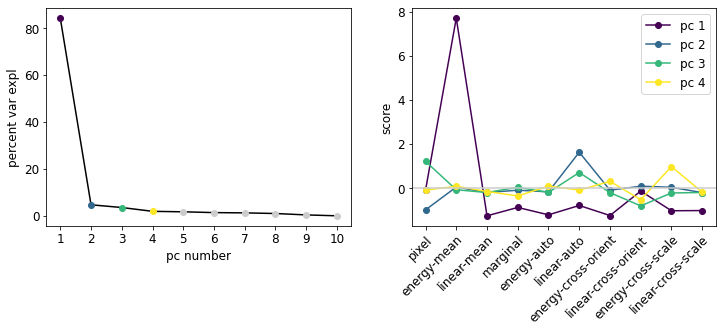

In [5]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plt.figure(figsize=(12,4));

plt.subplot(1,2,1)

pc_inds = [0,1,2,3]
pc_nums = [1,2,3,4]

ms = 6;

pc_colors = cm.viridis(np.linspace(0,1,4))

plt.plot(np.arange(1,11), ev,'-',color='k')
for pi, pc in zip(pc_inds, pc_nums):
    plt.plot(pc,ev[pi],'o', markersize=ms,color=pc_colors[pi,:])
for pi in np.arange(4,10):
    plt.plot(pi+1,ev[pi],'o',markersize=ms,color=[0.8, 0.8, 0.8])
    
plt.xticks(np.arange(1,11))
plt.ylabel('percent var expl')
plt.xlabel('pc number')

plt.subplot(1,2,2)

for pi, pc in zip(pc_inds, pc_nums):
    plt.plot(scores[:,pi],'o-', markersize=ms, color=pc_colors[pi,:])
plt.xticks(np.arange(10),feature_types_simple, rotation=45, ha='right',rotation_mode='anchor')
    
plt.axhline(0,color=[0.8, 0.8, 0.8])
plt.legend(['pc %d'%(pc) for pc in pc_nums])
plt.ylabel('score')


fn2save = os.path.join(default_paths.fig_path, 'uniquevar_pca_lineplots.pdf')
plt.savefig(fn2save)

#### Loading subject 1's images here.
This could be any subject, because we are only looking at the images that overlapped across all subjects.

In [6]:
image_data = nsd_utils.get_image_data(subject=1)
image_data = nsd_utils.image_uncolorize_fn(image_data)


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


#### Plot top and bottom images for each PC

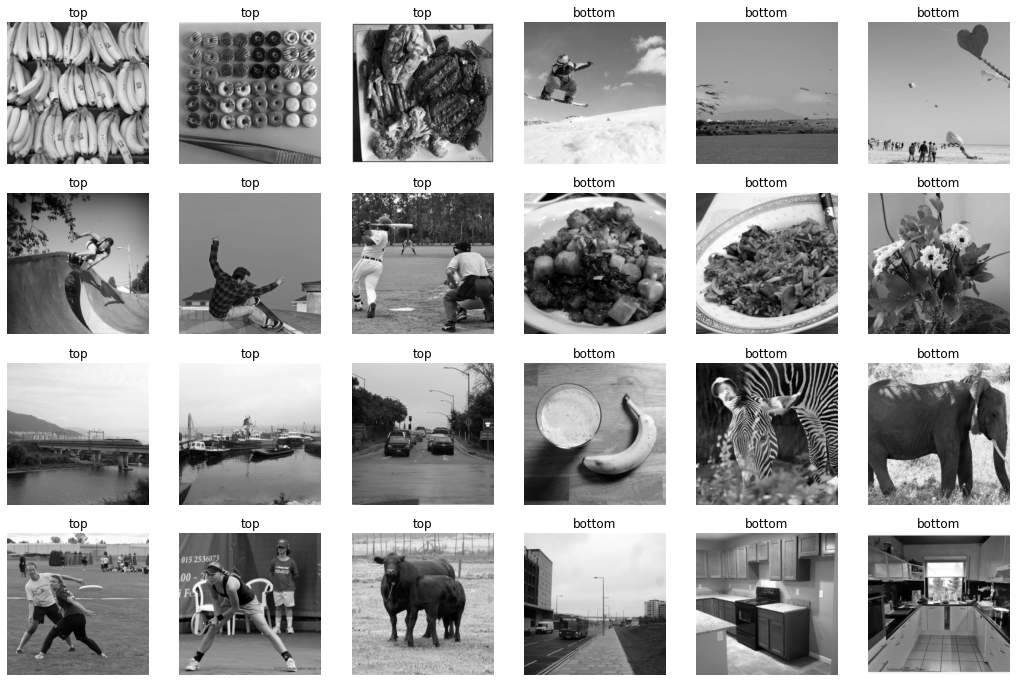

In [7]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)


top_n = 3;

n_pcs = 4;

pi = 0;

plt.figure(figsize=(18,12));

for pc in np.arange(n_pcs):

    ranked_ims = np.flip(np.argsort(proj[:,pc]))
    top_image_inds = image_inds[ranked_ims[0:5]]
    top_images = image_data[top_image_inds,0,:,:]

    
    for ii in range(top_n):
        pi+=1
        ax = plt.subplot(n_pcs,top_n*2,pi);
        plt.imshow(top_images[ii,:,:], cmap='gray')
        plt.axis('off')
        plt.title('top')

    ranked_ims = np.argsort(proj[:,pc])
    bottom_image_inds = image_inds[ranked_ims[0:5]]
    bottom_images = image_data[bottom_image_inds,0,:,:]

    for ii in range(top_n):
        pi+=1
        ax = plt.subplot(n_pcs,top_n*2,pi);
        plt.imshow(bottom_images[ii,:,:], cmap='gray')
        plt.axis('off')
        plt.title('bottom')
    
    # plt.suptitle('pc %d'%(pc+1));
    
fn2save = os.path.join(default_paths.fig_path, 'uniquevar_pca_topbottomimages.pdf')
plt.savefig(fn2save)

#### Making surface plots of weights using PyCortex

In [8]:
subjects = np.arange(1,9)
fitting_type = 'texture_pyramid_ridge_4ori_4sf_pcaHL_fit_pRFs'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) for ss in subjects]
 

In [9]:
volumes = {}

for si, ss in enumerate(subjects):
    
    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []

    vox2use = vox2use_all[si]
    n_vox = len(vox2use)
    weights_this_subj = wts[si]
    weights_full = np.zeros((n_vox,weights_this_subj.shape[1]))
    weights_full[vox2use,:] = weights_this_subj
 
    vox2plot = vox2use
    
    names += ['S%d: PC %d wts'%(ss, pc) for pc in [0,1,2,3]]
    maps += [weights_full[:,pc] for pc in [0,1,2,3]]
    cmaps += ['BrBG' for pc in [0,1,2,3]]

    mins += [-0.01 for pc in [0,1,2,3]]
    maxes += [0.01 for pc in [0,1,2,3]]
    
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)

In [10]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Texture model PCA summary', \
                                                port = 44443, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:44443
Started server on port 44443
Stopping server


In [13]:
viewname='flat'
viewer.get_view('subj01',viewname)


In [21]:
ss=2;

pc=3;

fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_texture_pc%d_weights_%s_raw.png'%(ss, pc, viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/texturemodel/figures/S02_texture_pc3_weights_flat_raw.png


[{}]

In [22]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [24]:
ss=1

In [25]:
import PIL
for pc in range(4):
    
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_pc%d_weights_%s_raw.png'%(ss, pc, viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                          'S%02d_texture_pc%d_weights_%s_cropped.png'%(ss, pc, viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000
3000


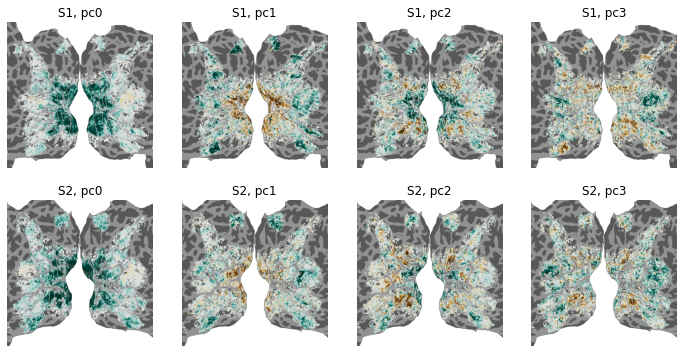

In [26]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plt.figure(figsize=(12,6))

pc2plot = [0,1,2,3]

pi = 0;

for si, ss in enumerate([1,2]):

    for pc in pc2plot:

        fn2save_cropped = os.path.join(default_paths.fig_path, \
                                       'S%02d_texture_pc%d_weights_%s_cropped.png'%(ss, pc, viewname))
        im = PIL.Image.open(fn2save_cropped)

        pi+=1
        plt.subplot(2,4,pi);
        plt.imshow(im)
        plt.title('S%d, pc%d'%(ss,pc))
        plt.axis('off')

fn2save = os.path.join(default_paths.fig_path, 'texture_uniquevar_pca.pdf')
plt.savefig(fn2save,dpi=1000)